<a href="https://colab.research.google.com/github/LonnyCox55/MSDS692_ParasiticInfectionCNN/blob/main/src/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lonny Cox-Lauf
#MSDS692: Data Science Practicum I
#CNN to Classify Parasitic Infection Type using Microscopic Images

This is the main Python notebook file that will clean the image data files, train, and evaluate the CNN models to classify types of parasitic eggs through microscopy.

In [1]:
# Import all necessary TensorFlow libraries
from tensorflow.keras import backend as K
from tensorflow.keras import backend
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Library for data augmentation
from tensorflow.keras.preprocessing import image

In [2]:
# Import all other necessary libraries for the project
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import display # Library to help view images
from PIL import Image # Library to help view images
import os, shutil # Library for navigating files
from google.colab import drive # Library to mount google drives
import glob
import json
import cv2 # For image cropping

In [ ]:
# TO DO: Import all the CNN model instantiation functions


In [3]:
# Seed the random number generator for consistency
np.random.seed(55)

In [4]:
# Mount the Google Drive to access the image data .zip files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# Un-zip all the training and testing image data files into Google Drive
!unzip gdrive/MyDrive/MSDS692_Practicum_I/data/Chula-ParasiteEgg-11.zip > /dev/null
#!unzip gdrive/MyDrive/MSDS692_Practicum_I/data/Chula-ParasiteEgg-11_test.zip > /dev/null TO DO: should I use this test data? It's unlabeled...

In [6]:
# Specify the base directory where all the images are located
baseDir = '/content/Chula-ParasiteEgg-11/Chula-ParasiteEgg-11/data'

In [7]:
# Crop each image based on the bounding boxes so they only include the egg
# Open JSON labels file that includes bounding boxes
labelsFile = open('/content/Chula-ParasiteEgg-11/Chula-ParasiteEgg-11/labels.json')

# Create JSON dictionary object
jsonContents = json.load(labelsFile)

# Iterate through images list from JSON file
for iImage in jsonContents['images']:
  imageId = iImage['id']
  fileName = iImage['file_name']

  # Iterate through all image file annotations
  for iAnnot in jsonContents['annotations']:

    # Find the image ID corresponding to the current file
    if iAnnot['image_id'] == imageId:

      # Extract the bounding box x, y (from top left corner of image), width, and height
      bbox = iAnnot['bbox']
      rowStart = int(bbox[1])
      rowEnd = rowStart + int(bbox[3])
      colStart = int(bbox[0])
      colEnd = colStart + int(bbox[2])

      # If the image is nonempty, crop it using OpenCV library
      cvImage = cv2.imread(os.path.join(baseDir, fileName))
      if cvImage.any():
        croppedImage = cvImage[rowStart:rowEnd, colStart:colEnd]

        # Save the cropped image (overwrite existing file)
        if croppedImage.any():
          cv2.imwrite(os.path.join(baseDir, fileName), croppedImage)
        else:
          #print('Image ', fileName, ' was empty after cropping...')

      else:
        #print('Image ', fileName, ' was empty...')

# Close the labels JSON file
labelsFile.close()

Image  Hymenolepis nana_0680.jpg  was empty after cropping...
Image  Ascaris lumbricoides_0060.jpg  was empty after cropping...
Image  Ascaris lumbricoides_0099.jpg  was empty after cropping...
Image  Ascaris lumbricoides_0133.jpg  was empty after cropping...
Image  Ascaris lumbricoides_0137.jpg  was empty after cropping...
Image  Ascaris lumbricoides_0153.jpg  was empty after cropping...
Image  Ascaris lumbricoides_0208.jpg  was empty after cropping...
Image  Ascaris lumbricoides_0209.jpg  was empty after cropping...
Image  Ascaris lumbricoides_0217.jpg  was empty after cropping...
Image  Ascaris lumbricoides_0218.jpg  was empty after cropping...
Image  Ascaris lumbricoides_0256.jpg  was empty after cropping...
Image  Ascaris lumbricoides_0637.jpg  was empty after cropping...
Image  Ascaris lumbricoides_0665.jpg  was empty after cropping...
Image  Ascaris lumbricoides_0709.jpg  was empty after cropping...
Image  Ascaris lumbricoides_0817.jpg  was empty after cropping...
Image  Ascaris

In [8]:
# Iterate through all 11 classifications of parasitic eggs
for eggClass in ("Hymenolepis*nana*", "Ascaris*lumbricoides*", "Enterobius*vermicularis*", "Capillaria*philippinensis*", "Hymenolepis*diminuta*", "Paragonimus*spp*", "Trichuris*trichiura*", "Fasciolopsis*buski*", "Opisthorchis*viverrine*", "Taenia*spp*", "Hookworm*"):
  eggFiles = glob.glob(eggClass, root_dir = baseDir) # Find all egg image files that match the current class
  classDirName = eggClass.replace("*", "_")          # Replace * with underscore for the new subdirectory names
  np.random.shuffle(eggFiles)                        # Randomize the files
  numTestFiles = int(0.2*len(eggFiles))              # Find 20% of the number of files for the test set
  testFiles = eggFiles[-numTestFiles:]               # Create subset of the data files for the test set

  # Move each test file to the respective test set directory
  os.makedirs(baseDir + "/test/" + classDirName) # Create new test directory
  for fname in testFiles:
    shutil.move(baseDir + "/" + fname,                           # Source
                baseDir + "/test/" + classDirName + "/" + fname) # Destination

  numValFiles = int(0.16*len(eggFiles))                          # Find 20% of the remaining (training set) files for the validation set
  valFiles = eggFiles[-(numTestFiles+numValFiles):-numTestFiles] # Create subset of the data files for the validation set

  # Move each validation file to the respective validation set directory
  os.makedirs(baseDir + "/val/" + classDirName) # Create new validation directory
  for fname in valFiles:
    shutil.move(baseDir + "/" + fname,                           # Source
                baseDir + "/val/" + classDirName + "/" + fname)  # Destination

  # Create subset of the data files for the training set
  numTrainFiles = len(eggFiles) - numTestFiles - numValFiles
  trainFiles = eggFiles[:numTrainFiles]

  # Move each training file to the respective training set directory
  os.makedirs(baseDir + "/train/" + classDirName) # Create new train directory
  for fname in trainFiles:
    shutil.move(baseDir + "/" + fname,                            # Source
                baseDir + "/train/" + classDirName + "/" + fname) # Destination

In [9]:
# Verify the new parasitic egg class subdirectories contain the correct split of data image files
# (using Hymenolepis nana as an example)
print("Number of training images: ", len(os.listdir(baseDir + "/train/Hymenolepis_nana_")))
print("Number of validation images: ", len(os.listdir(baseDir + "/val/Hymenolepis_nana_")))
print("Number of test images: ", len(os.listdir(baseDir + "/test/Hymenolepis_nana_")))

Number of training images:  640
Number of validation images:  160
Number of test images:  200


In [10]:
# Specify the training, validation, and test directories
trainDir = os.path.join(baseDir, 'train')
valDir = os.path.join(baseDir, 'val')
testDir = os.path.join(baseDir, 'test')

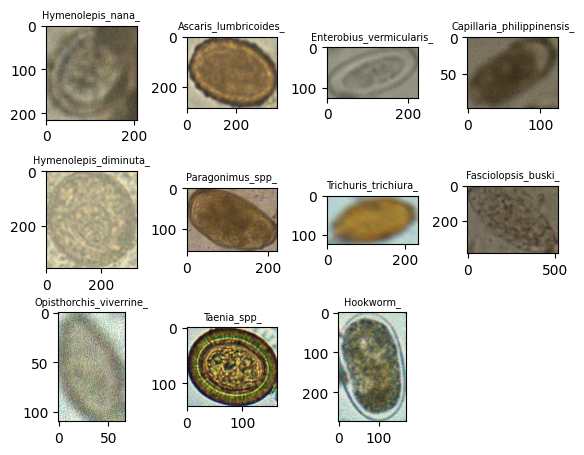

In [11]:
# Plot one of each type of parasitic egg classification from training set
i = 1
for category in ("Hymenolepis_nana_", "Ascaris_lumbricoides_", "Enterobius_vermicularis_", "Capillaria_philippinensis_", "Hymenolepis_diminuta_", "Paragonimus_spp_", "Trichuris_trichiura_", "Fasciolopsis_buski_", "Opisthorchis_viverrine_", "Taenia_spp_", "Hookworm_"):
  fullPath = os.path.join(trainDir, category)
  img = image.load_img(os.path.join(fullPath, os.listdir(fullPath)[1]))
  plt.subplot(3, 4, i)
  imgplot = plt.imshow(img)
  plt.title(category, fontsize=7)
  i += 1
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, hspace=0.35, wspace=0.55)
plt.show()

In [12]:
# Create image data generator for test data
testDatagen = ImageDataGenerator(rescale=1./255) # Just normalize pixels for test data, no augmentation

# Create image data generator for training data using Keras data augmentation techniques
trainDatagen = ImageDataGenerator(
    rescale=1./255,          # Normalize the pixel data so values are between 0 and 1 instead of 0 and 255
    rotation_range=30,       # Rotate the images randomly up to 30 degrees
    shear_range=0.1,         # Shear image up to 10%
    horizontal_flip=True,    # Flip image horizontally
    vertical_flip=True,      # Flip image vertically
    fill_mode='nearest')     # How to fill missing pixels after a augmentaion operation

In [13]:
# Create Keras flow from directory object that will move the training images from the directory into the model
trainGenerator = trainDatagen.flow_from_directory(
    trainDir,                 # The directory where the training data is located
    target_size=(256, 256),   # Resize images to 256 by 256 pixels
    batch_size=32,            # We will take images in batches of 32
    class_mode='categorical') # The classification is categorical since 11 possible labels

# Repeat for validation images
valGenerator = trainDatagen.flow_from_directory(
    valDir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical')

# Repeat for test images
testGenerator = testDatagen.flow_from_directory(
    testDir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical')

Found 7040 images belonging to 11 classes.
Found 1760 images belonging to 11 classes.
Found 2200 images belonging to 11 classes.


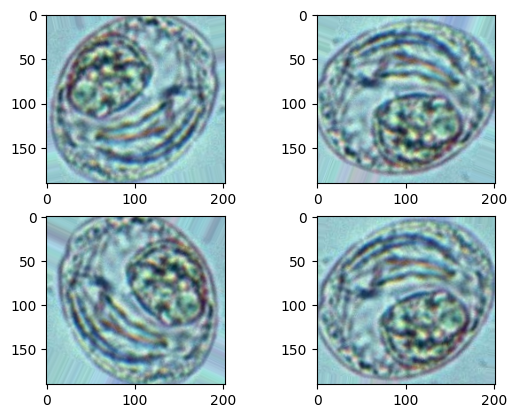

In [14]:
# Demonstrate the data augmentation using the first image of Hymenolepis nana from training set
hymenoNanaDir = os.path.join(trainDir, "Hymenolepis_nana_")
img = image.load_img(os.path.join(hymenoNanaDir, os.listdir(hymenoNanaDir)[0]))
imgArr = image.img_to_array(img)
imgArr = imgArr.reshape((1,) + imgArr.shape)

# Plot the first 4 augmented versions of the image
i = 1
for batch in trainDatagen.flow(imgArr, batch_size=1):
    plt.subplot(2, 2, i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i == 5:
        break
plt.show()

In [15]:
# Build a plotting function
def plot_history():
  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  acc_values = history_dict['accuracy']
  val_acc_values = history_dict['val_accuracy']
  epochs = range(1, len(history_dict['accuracy']) + 1)

  plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
  plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
  plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  return plt.show()

In [16]:
# Build an initial, basic model
def Parasite_Basic_CNN():
  backend.clear_session()
  model = models.Sequential()

  model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same', input_shape = (256, 256, 3)))
  model.add(layers.MaxPool2D((2,2)))
  model.add(BatchNormalization())

  model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
  model.add(layers.MaxPool2D((2,2)))
  model.add(BatchNormalization())

  model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
  model.add(layers.MaxPool2D((2,2)))
  model.add(BatchNormalization())

  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(11, activation='softmax')) # Use softmax for multi-class classification (11 nodes for 11 classes)

  model.compile(optimizer = 'rmsprop',
                loss = 'categorical_crossentropy', # Use categorical crossentropy for multi-class classification
                metrics = ['accuracy'])
  return model

In [17]:
# Create the basic model
model = Parasite_Basic_CNN()

Epoch 1/20
220/220 [==============================] - 146s 628ms/step - loss: 2.9517 - accuracy: 0.0854 - val_loss: 4.1527 - val_accuracy: 0.0898
Epoch 2/20
220/220 [==============================] - 136s 619ms/step - loss: 2.4063 - accuracy: 0.0862 - val_loss: 2.8581 - val_accuracy: 0.0932
Epoch 3/20
220/220 [==============================] - 152s 690ms/step - loss: 2.3984 - accuracy: 0.0842 - val_loss: 2.3973 - val_accuracy: 0.0926
Epoch 4/20
220/220 [==============================] - 149s 680ms/step - loss: 2.4109 - accuracy: 0.0871 - val_loss: 2.3979 - val_accuracy: 0.0909
Epoch 5/20
220/220 [==============================] - 136s 617ms/step - loss: 2.4039 - accuracy: 0.0891 - val_loss: 2.4063 - val_accuracy: 0.0926
Epoch 6/20
220/220 [==============================] - 138s 627ms/step - loss: 2.4037 - accuracy: 0.0848 - val_loss: 2.3953 - val_accuracy: 0.0920
Epoch 7/20
220/220 [==============================] - 136s 620ms/step - loss: 2.4175 - accuracy: 0.0852 - val_loss: 2.3995 -

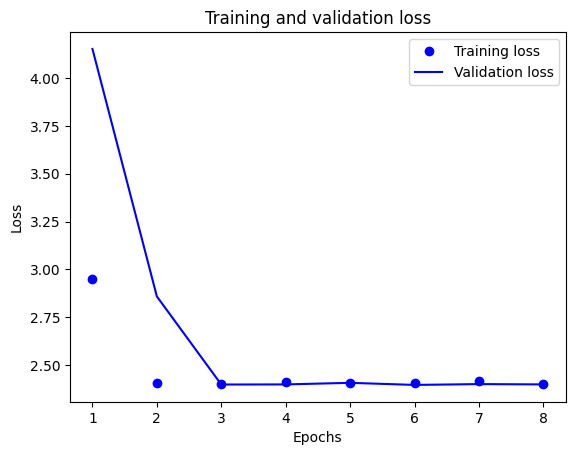

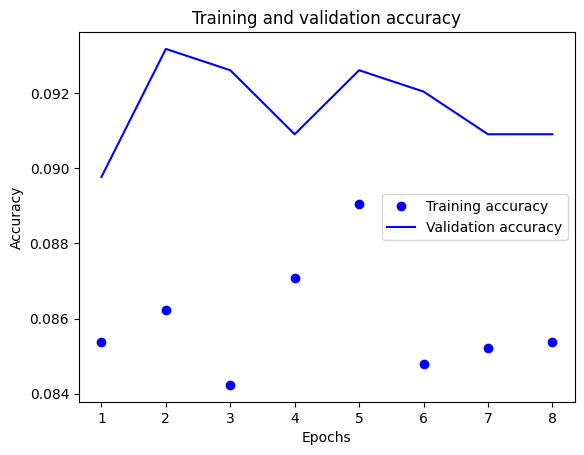

68/68 [==============================] - 5s 80ms/step - loss: 2.7669 - accuracy: 0.0896
Test Accuracy of model: 0.08961397409439087


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
history = model.fit( # The image data must come from the image generator that takes the images from the correct directory
    trainGenerator,  # Images are taken from the trainGenerator
    steps_per_epoch=220, # The number of steps from the trainGenerator before one epoch is finished.
                         # 220 steps * 32 batch size in train generator = 7040 training images per epoch.
                         # This way every training image will be sampled once per epoch.
    epochs=20, # Train data over a max of 20 epochs
    validation_data=valGenerator, # Take data from the validation generator
    validation_steps=55,          # 55 steps * 32 batch size in validation generator = 1760 validation images per epoch
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights = True)]) # Stop once validation accuracy peaks

# Use our plot function to plot the loss and accuracy
plot_history()

# Evaluate the model on the test images and print the results
testLoss, testAcc = model.evaluate(testGenerator, steps = 68) # Test images are in a directory so they must flow from directory
                                                              # 68 steps * 32 batch size in test generator ~= 2200 test images per epoch
print('Test Accuracy of model:', testAcc)

# Save the model for future use
model.save('Parasite_Basic_CNN.h5')